<a href="https://colab.research.google.com/github/ChintPatel/CMPE258-HW8-Computer-Vision/blob/main/HW8_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8282 - loss: 0.5599 - val_accuracy: 0.9415 - val_loss: 0.1812
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.9754 - loss: 0.0863 - val_accuracy: 0.9510 - val_loss: 0.1509
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9907 - loss: 0.0368 - val_accuracy: 0.9545 - val_loss: 0.1439
Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: nan   
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: nan
Epoch 3/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: nan


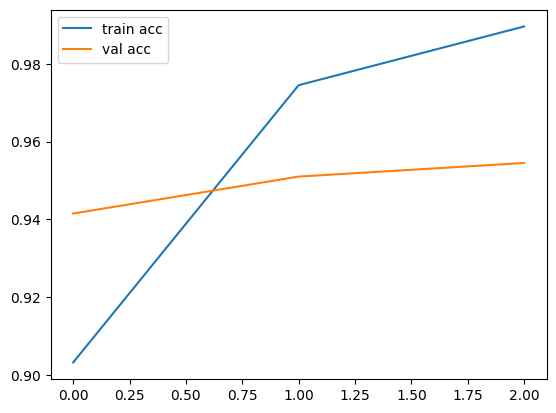

In [2]:
# ─── CELL 1: no pip installs ───
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Custom supervised contrastive loss (from Keras example)
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def call(self, labels, feature_vectors):
        # normalize embeddings
        features = tf.math.l2_normalize(feature_vectors, axis=1)
        # cosine similarity matrix
        logits = tf.matmul(features, features, transpose_b=True) / self.temperature

        # mask to zero out self-comparisons
        labels = tf.squeeze(labels)
        mask = tf.cast(tf.equal(tf.expand_dims(labels,1), tf.expand_dims(labels,0)), tf.float32)
        logits_mask = tf.ones_like(mask) - tf.eye(tf.shape(labels)[0])
        mask *= logits_mask

        # log‐softmax over rows
        exp_logits = tf.exp(logits) * logits_mask
        log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

        # mean log‐prob of positive pairs
        mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / tf.reduce_sum(mask, axis=1)
        loss = -tf.reduce_mean(mean_log_prob_pos)
        return loss

# Prepare MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[...,None]/255.0; x_test = x_test[...,None]/255.0
x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test   = x_test[:2000],   y_test[:2000]
y_train_sc = y_train.reshape(-1,1)

# Base encoder
def get_base():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,3,activation='relu',input_shape=(28,28,1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation='relu'),
    ])

# 1) Softmax model
soft = tf.keras.Sequential(get_base().layers + [tf.keras.layers.Dense(10)])
soft.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)
soft.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

# 2) Contrastive model
contrastive = tf.keras.Sequential([
    get_base(),
    tf.keras.layers.Dense(128)  # projection head
])
contrastive.compile(
    optimizer='adam',
    loss=SupervisedContrastiveLoss(temperature=0.1),
)
contrastive.fit(x_train, y_train_sc, epochs=3, batch_size=128)

# Plot Softmax accuracy
plt.plot(soft.history.history['accuracy'], label='train acc')
plt.plot(soft.history.history['val_accuracy'], label='val acc')
plt.legend(); plt.show()


In [3]:
# ─── CELL A: Install TF-Hub & Transformers ───
!pip install -q tensorflow_hub transformers


In [7]:
# ─── CELL B: PART 2 – IMAGE TRANSFER LEARNING (CIFAR-10) ───
import tensorflow as tf
import numpy as np

# 1) Load CIFAR-10 into fresh vars
(xc_train, yc_train), (xc_test, yc_test) = tf.keras.datasets.cifar10.load_data()

# 2) Preprocess & cast
x_train_img = xc_train.astype('float32')[:5000] / 255.0
y_train_img = yc_train.astype('int32')[:5000].squeeze()
x_val_img   = xc_test .astype('float32')[:1000] / 255.0
y_val_img   = yc_test .astype('int32')[:1000].squeeze()

# Confirm dtypes
print("x_train:", x_train_img.dtype, "y_train:", y_train_img.dtype)

# 3) Build MobileNetV2-based classifier
base = tf.keras.applications.MobileNetV2(
    input_shape=(32,32,3), include_top=False,
    weights='imagenet', pooling='avg'
)
base.trainable = False

model_img = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32,32,3)),
    base,
    tf.keras.layers.Dense(10)
])
model_img.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4) Feature-extraction training
model_img.fit(
    x_train_img, y_train_img,
    epochs=2, batch_size=64,
    validation_data=(x_val_img, y_val_img)
)

# 5) Fine-tune last 20 layers
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False

model_img.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_img.fit(
    x_train_img, y_train_img,
    epochs=2, batch_size=64,
    validation_data=(x_val_img, y_val_img)
)



# 2.2 Audio – YAMNet embeddings
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')
fake_audio = np.random.uniform(-1,1,16000).astype(np.float32)
scores, embeddings, spec = yamnet(fake_audio)
print('YAMNet embeddings →', embeddings.shape)



# 2.4 NLP – Universal Sentence Encoder
use = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
texts = ["TensorFlow is great!", "Transfer learning demo"]
text_emb = use(texts)
print('Text embeddings →', text_emb.shape)


x_train: float32 y_train: int32


<ipython-input-7-926b950d9fbf>:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.1120 - loss: 7.3608 - val_accuracy: 0.1650 - val_loss: 5.3268
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.1866 - loss: 5.0295 - val_accuracy: 0.1870 - val_loss: 4.1541
Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.1068 - loss: 10.7015 - val_accuracy: 0.1700 - val_loss: 4.4617
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.1190 - loss: 10.3075 - val_accuracy: 0.1460 - val_loss: 5.3948
YAMNet embeddings → (2, 1024)
Text embeddings → (2, 512)


In [2]:
# ─── CELL C: PART 3 – ZERO-SHOT CLIP & SOTA MINI DEMO ───
import tensorflow as tf
import tensorflow_hub as hub
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import numpy as np

# 3.1 Zero-shot CLIP (same as before)
clip_model     = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

url = "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png"
img = Image.open(requests.get(url, stream=True).raw).convert("RGB").resize((224,224))

inputs = clip_processor(
    text=["a cat","a dog","a PNG image"],
    images=img,
    return_tensors="pt", padding=True
)
out   = clip_model(**inputs)
probs = out.logits_per_image.softmax(dim=1)
print("CLIP probs →", probs.tolist())

# 3.2 EfficientNetB0 – train on 500 CIFAR samples @96×96
# 1) Reload & cast CIFAR
(xc_full, yc_full), _ = tf.keras.datasets.cifar10.load_data()
xc = xc_full[:500].astype('float32')  / 255.0
yc = yc_full[:500].astype('int32').squeeze()

print("After casting:", xc.dtype, yc.dtype)
# Should print: float32, int32

# 2) Build the model (96×96 mini‐version)
model_en = tf.keras.Sequential([
    tf.keras.layers.Resizing(96,96),
    tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        pooling='avg'
    ),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_en.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3) Wrap in a Dataset to guarantee dtypes
ds = tf.data.Dataset.from_tensor_slices((xc, yc))\
                   .shuffle(500).batch(16)

# 4) Train
model_en.fit(ds, epochs=1, verbose=2)
print("EfficientNet mini‐train done")

# 3.3 BiT-S R50x1 – inference only on one random image
bit_layer = hub.KerasLayer(
    "https://tfhub.dev/google/bit/s-r50x1/1",
    trainable=False
)
sample = tf.random.normal([1,224,224,3])
feats  = bit_layer(sample)
print("BiT embedding shape →", feats.shape)


CLIP probs → [[0.0004993799957446754, 0.0012223446974530816, 0.9982782602310181]]
After casting: float32 int32
32/32 - 79s - 2s/step - accuracy: 0.3900 - loss: 1.7647
EfficientNet mini‐train done
BiT embedding shape → (1, 2048)


In [3]:
# ─── CELL D: PART 4 – X-RAY & 3D CT DEMOS (synthetic data) ───
import tensorflow as tf
import numpy as np

# 4.1 X-ray pneumonia classification (2D convnet on fake data)
# ------------------------------------------------------------
# create 1,000 random "grayscale X-ray" images (128×128) and binary labels
X2d = np.random.rand(1000, 128, 128, 1).astype('float32')
y2d = np.random.randint(0, 2, size=(1000,))

# train/test split
x2d_train, y2d_train = X2d[:800], y2d[:800]
x2d_val,   y2d_val   = X2d[800:], y2d[800:]

model2d = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(128,128,1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2d.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)
print("Training 2D X-ray pneumonia convnet on synthetic data…")
model2d.fit(
    x2d_train, y2d_train,
    epochs=3,
    validation_data=(x2d_val, y2d_val)
)


# 4.2 3D CT-scan classification (3D convnet on fake volumes)
# ------------------------------------------------------------
# create 200 random "3D CT volumes" (32×32×32) and binary labels
X3d = np.random.rand(200, 32, 32, 32, 1).astype('float32')
y3d = np.random.randint(0, 2, size=(200,))

# train/test split
x3d_train, y3d_train = X3d[:160], y3d[:160]
x3d_val,   y3d_val   = X3d[160:], y3d[160:]

model3d = tf.keras.Sequential([
    tf.keras.layers.Conv3D(8, 3, activation='relu', input_shape=(32,32,32,1)),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3d.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)
print("\nTraining 3D CT-scan convnet on synthetic volumes…")
model3d.fit(
    x3d_train, y3d_train,
    epochs=3,
    validation_data=(x3d_val, y3d_val)
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training 2D X-ray pneumonia convnet on synthetic data…
Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.5062 - loss: 0.7936 - val_accuracy: 0.4750 - val_loss: 0.6942
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step - accuracy: 0.5230 - loss: 0.6926 - val_accuracy: 0.4750 - val_loss: 0.6954
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.5130 - loss: 0.6913 - val_accuracy: 0.5250 - val_loss: 0.6921

Training 3D CT-scan convnet on synthetic volumes…
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5030 - loss: 0.8624 - val_accuracy: 0.5750 - val_loss: 0.6930
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5306 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6922
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4989 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6965
